In [1]:
# Import necessary libraries
import torch.cuda as torch_cuda
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [2]:
print('===VERIFY GPU===')
print('CUDA IS AVAILABLE:', torch_cuda.is_available())
print('DEVICE COUNT:', torch_cuda.device_count())
print('DEVICE NAME:', torch_cuda.get_device_name(0))

# If CUDA is available, print GPU details
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0)} bytes")
    print(f"GPU Memory Cached: {torch.cuda.memory_reserved(0)} bytes")

# Select device: GPU if available, otherwise CPU
device = torch.device('cuda:0' if torch_cuda.is_available() else 'cpu')


===VERIFY GPU===
CUDA IS AVAILABLE: True
DEVICE COUNT: 1
DEVICE NAME: NVIDIA RTX A4000
Number of GPUs: 1
GPU Name: NVIDIA RTX A4000
GPU Memory Allocated: 0 bytes
GPU Memory Cached: 0 bytes


## Training Data

In [3]:
# Define hyperparameters
batch_size = 16

# Define transformations: Convert to tensor and normalize
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

mnist_trainset = datasets.MNIST(
    root='../Data',
    train=True,
    download=True,
    transform=transformations
)

mnist_testset = datasets.MNIST(
    root='../Data',
    train=False,
    download=True,
    transform=transformations
)

trainloader = DataLoader(
    mnist_trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = DataLoader(
    mnist_testset,
    batch_size=batch_size,
    shuffle=False,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


TRAIN SET LENGTH: 60000
TEST SET LENGTH: 10000


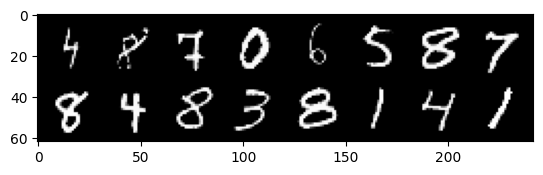

In [4]:
print('TRAIN SET LENGTH:', len(mnist_trainset))
print('TEST SET LENGTH:', len(mnist_testset))

def imshow(img):

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), vmin=0, vmax=1)
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(make_grid(images))

## MLP

In [5]:
momentum_coeff = 0.9
learning_rate = 0.01
learning_decay = 10**-9
epochs = 100

# Classes for MNIST digits
classes = (0,1,2,3,4,5,6,7,8,9)

In [6]:
# Define a multi-layer perceptron (MLP) model
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        # Flatten layer to convert 28x28 images into 784-dim vector
        self.flat = nn.Flatten()

        # Define linear layers
        self.input_layer = nn.Linear(784, 1000)
        self.hidden_layer1 = nn.Linear(1000, 1000)
        self.hidden_layer2 = nn.Linear(1000, 1000)
        self.hidden_layer3 = nn.Linear(1000, 1000)
        self.hidden_layer4 = nn.Linear(1000, 1000)
        self.out = nn.Linear(1000, 10)

        # Define dropout layers
        self.dropout_layer1 = nn.Dropout(p=0.2)
        self.dropout_layer2 = nn.Dropout(p=0.3)
        self.dropout_layer3 = nn.Dropout(p=0.4)
        self.dropout_layer4 = nn.Dropout(p=0.5)

    def forward(self, x, output=5):
        # Flatten the image into a 784-dim vector
        x = x.reshape(-1, 784)

        # Pass through layers with ReLU activation and dropout
        x = F.relu(self.input_layer(x))

        x = F.relu(self.hidden_layer1(x))
        if output == 1:
            return x
        x = self.dropout_layer1(x)
        
        x = F.relu(self.hidden_layer2(x))
        if output == 2:
            return x
        x = self.dropout_layer2(x)
        
        x = F.relu(self.hidden_layer3(x))
        if output == 3:
            return x
        x = self.dropout_layer3(x)
        
        x = F.relu(self.hidden_layer4(x))
        if output == 4:
            return x
        x = self.dropout_layer4(x)
        
        # IMPORTANT FIX: Do not apply softmax here.
        # CrossEntropyLoss expects raw logits.
        x = self.out(x)
        return x  # Return raw logits

# Instantiate and move model to the selected device
mlp = MLP().to(device)

loss_function = nn.CrossEntropyLoss()  # CrossEntropyLoss expects raw logits
optimizer = optim.SGD(mlp.parameters(), lr=learning_rate,
                      momentum=momentum_coeff, weight_decay=learning_decay)


def train(epoch):

    mlp.train()
    for batch_idx, (data, target) in enumerate(trainloader):

        data, target = data.to(device), target.to(device)


        optimizer.zero_grad()

        output = mlp(data, output=5)


        loss = loss_function(output, target)

        loss.backward()

        optimizer.step()

        if batch_idx % 25 == 0:
            print('Train Epoch: {:>3}\t[{:>5}/{:>5} ({:>3.0f}%)]\tLoss: {:>7.6f}'.format(
                epoch + 1, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))


def test():
    mlp.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in testloader:
            # Move data and targets to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = mlp(data, output=5)

            # Compute loss and accumulate
            test_loss += loss_function(output, target).item()

            # Get predicted classes
            pred = output.argmax(dim=1, keepdim=True)

            # Count how many predictions are correct
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Average loss over the entire test set
    test_loss /= len(testloader)

    # Print test performance
    print('\nTest set: Average loss: {:>10.4f}, Accuracy: {:>5}/{:>5} ({:>3.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))


# Run the training and testing for defined epochs
for epoch in range(epochs):
    train(epoch)
    test()


Train Epoch:   1	[    0/60000 (  0%)]	Loss: 2.305076
Train Epoch:   1	[  400/60000 (  1%)]	Loss: 2.293404
Train Epoch:   1	[  800/60000 (  1%)]	Loss: 2.300701
Train Epoch:   1	[ 1200/60000 (  2%)]	Loss: 2.257620
Train Epoch:   1	[ 1600/60000 (  3%)]	Loss: 2.315033
Train Epoch:   1	[ 2000/60000 (  3%)]	Loss: 2.302356
Train Epoch:   1	[ 2400/60000 (  4%)]	Loss: 2.094705
Train Epoch:   1	[ 2800/60000 (  5%)]	Loss: 1.452890
Train Epoch:   1	[ 3200/60000 (  5%)]	Loss: 1.866568
Train Epoch:   1	[ 3600/60000 (  6%)]	Loss: 1.121219
Train Epoch:   1	[ 4000/60000 (  7%)]	Loss: 0.844084
Train Epoch:   1	[ 4400/60000 (  7%)]	Loss: 0.722686
Train Epoch:   1	[ 4800/60000 (  8%)]	Loss: 0.624115
Train Epoch:   1	[ 5200/60000 (  9%)]	Loss: 0.828276
Train Epoch:   1	[ 5600/60000 (  9%)]	Loss: 1.008619
Train Epoch:   1	[ 6000/60000 ( 10%)]	Loss: 1.222274
Train Epoch:   1	[ 6400/60000 ( 11%)]	Loss: 0.860265
Train Epoch:   1	[ 6800/60000 ( 11%)]	Loss: 0.771572
Train Epoch:   1	[ 7200/60000 ( 12%)]	Loss: 0.

In [7]:
torch.save(mlp.state_dict(), '../Saved/MNIST_MLP_TRAINED.pt')

### Get Layer Activations

In [ ]:
def get_activations(layer = 4):
    activations = []
    labels = []
    predictions = []
    with torch.no_grad():

        #  Train Data Activations
        for data, target in trainloader:
            # Move data and targets to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = mlp(data, output=layer)
            for t in output:
                activations.append(t.to('cpu').numpy())
            labels.append(target.to('cpu').numpy())

            output = mlp(data, output=5)
            for t in output:
                pred = np.argmax(t.to('cpu').numpy())
                predictions.append(pred)

        #  Test Data Activations
        for data, target in testloader:
            # Move data and targets to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = mlp(data, output=layer)
            for t in output:
                activations.append(t.to('cpu').numpy())
            labels.append(target.to('cpu').numpy())

            output = mlp(data, output=5)
            for t in output:
                pred = np.argmax(t.to('cpu').numpy())
                predictions.append(pred)

    return activations, labels, predictions

activations, labels, predictions = get_activations(4)

In [9]:
activations = np.array(activations)

predictions_df = pd.DataFrame(predictions, columns=['prediction'])
labels_df = pd.DataFrame(np.array(labels).flatten(), columns=['class'])
labels_df.head()

,class
0,8
1,6
2,8
3,8
4,3


### Dimensionality Reduction

In [10]:
from sklearn.manifold import TSNE

dim_red = TSNE(n_components = 2, random_state=0)
points = dim_red.fit_transform(activations)
points

array([[  56.386856,   59.942955],
       [ -17.469141, -108.739296],
       [  64.97552 ,   34.50658 ],
       ...,
       [ -12.077104,  103.292656],
       [   4.3767  ,  -17.531544],
       [ -40.932503,  -89.4539  ]], dtype=float32)

### Quick Plot

<Axes: xlabel='x', ylabel='y'>

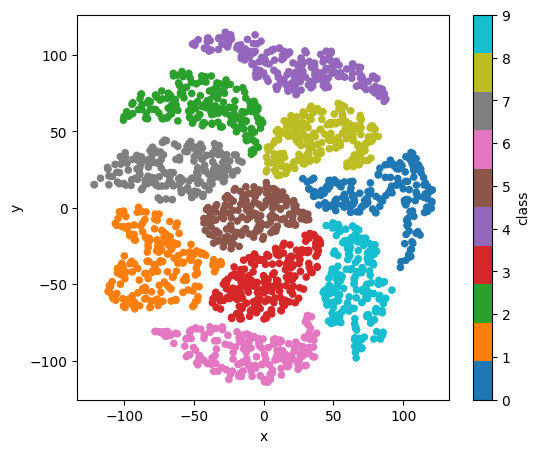

In [11]:
# Quick plot to check data
points_df = pd.DataFrame(points, columns=['x','y']).join(labels_df).join(predictions_df)

plt.rcParams["figure.figsize"] = [6, 5]
points_df[0:2000].plot.scatter(
    x='x',
    y='y',
    c='class',
    colormap='tab10'
)

In [12]:
points_df.to_csv('../Outputs/MNIST_MLP_LAYER_4_WITH_PREDICTIONS_2.csv', index=False)

In [13]:
points_df.head()

,x,y,class,prediction
0,56.386856,59.942955,8,8
1,-17.469141,-108.739296,6,6
2,64.975517,34.506580,8,8
3,69.785805,52.287910,8,8
4,-15.585555,-66.093208,3,3
